# Data Binning

Diskretisasi atau *data binning* adalah proses mengubah nilai numerik kontinu menjadi nilai kategori dengan cara membaginya ke dalam sejumlah kelompok atau *bin*.


Teknik ini umum digunakan dalam tahap preprocessing data untuk menyederhanakan analisis, mempercepat pemodelan,mengatasi data yang tidak stabil, dan serta meningkatkan performa algoritma tertentu yang lebih cocok bekerja dengan data kategorikal.

Pada halaman ini saya akan membandingkan berbagai metode diskretisasi , seperti equal width, equal frequency, dan berbasis clustering seperti K-Means.

In [1]:

%pip install pymysql
%pip install psycopg2

Kita ambil dataset dari database

In [3]:

import pymysql
import psycopg2
import numpy as np
import pandas as pd

def get_mysql_data():
    conn = pymysql.connect(
        host="pendatviomysql-39-projectvioo.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_nnGCVuLriFaCit_hSPr",
        database="myiris",
        port=20305
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")  # Select all records from the table
    data = cursor.fetchall()  # Fetch all rows
    conn.close()
    # Convert to Python list
    data_list = [list(row) for row in data]
    # Convert to NumPy array
    data_numpy = np.array(data_list)
    return data_list



def get_pg_data():
    conn = psycopg2.connect(
        host="pg-30810f3a-projectvioo.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_zzD9DhqapmhcWhqwe5C",
        database="defaultdb",
        port=20305
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_post")  # Select all records from the table
    data = cursor.fetchall()  # Fetch all rows
    cursor.close()
    conn.close()

    # Convert to Python list
    data_list = [list(row) for row in data]

    # Convert to NumPy array
    data_numpy = np.array(data_list)

    return data_list

columns = ['id', 'Class', 'sepal_length', 'sepal_width']
data_mysql = pd.DataFrame(get_mysql_data(), columns=columns)

columns = ['id', 'Class', 'petal_length', 'petal_width']
data_pg = pd.DataFrame(get_pg_data(), columns=columns)

df_merged = pd.merge(data_mysql, data_pg, on=["id", "Class"], how="inner")
print(df_merged)




      id           Class  sepal_length  sepal_width  petal_length  petal_width
0      1     Iris-setosa           1.4          0.2           5.1          3.5
1      2     Iris-setosa          14.0          2.0          40.9         30.0
2      3     Iris-setosa           1.3          0.2           4.7          3.2
3      4     Iris-setosa           1.5          0.2           4.6          3.1
4      5     Iris-setosa           1.4          0.2           5.0          3.6
..   ...             ...           ...          ...           ...          ...
145  146  Iris-virginica           5.2          2.3           6.7          3.0
146  147  Iris-virginica           5.0          1.9           6.3          2.5
147  148  Iris-virginica           5.2          2.0           6.5          3.0
148  149  Iris-virginica           5.4          2.3           6.2          3.4
149  150  Iris-virginica           5.1          1.8           5.9          3.0

[150 rows x 6 columns]


melakukan klasifikasi terhadap data yang diskritisasi menggunakan equal width , equal freq , kmean kategori dan belum kategori , gunakan klasifikasi menggunakan naive bayes dan pohon keputusan


## Tahap Preprocessing
Pada tahap preprocessing, dilakukan serangkaian langkah untuk mempersiapkan data sebelum digunakan dalam proses pemodelan.
kali ini saya akan melakukan tahap preprocessing berikut :
1. Pembersihan data
2. Diskretisasi data





### Pembersihan data
dalam tahap ini kita akan membersihkan data dari Outlier atau data aneh yang dapat berpengaruh buruk pada kualitas model. Untuk membersihkan data,saya menggunakan LOF (local Outlier Factor) untuk mendeteksi Outlier dan memperbaiki nya menggunakan regresi linear, hal ini di lakukan untuk menghindari ketidakseimbangan data antar kelas bunga Iris dan juga menjaga jumlah data, dan alasan saya menggunakan regresi linear karena relatif sederhana dibandingkan algoritma regresi lain serta lebih akurat dibanding menggunakan rata rata / means.



-----------

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor

# Dataframe awal dengan data kotor dan outlier
datab = df_merged.copy(deep=True)
feature_columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# Deteksi outlier menggunakan LOF
clf = LocalOutlierFactor(n_neighbors=20)
outlier_labels = clf.fit_predict(datab[feature_columns])
datab["outlier_label"] = outlier_labels

# Hitung jumlah data normal dan outlier
num_outliers = (datab["outlier_label"] == -1).sum()
num_normal = (datab["outlier_label"] == 1).sum()

# Pisahkan data menjadi normal dan outlier
df_normal = datab[datab["outlier_label"] == 1]
df_outlier = datab[datab["outlier_label"] == -1]

# Iterasi setiap kelas untuk memperbaiki outlier
classes = df_normal["Class"].unique()
for class_name in classes:
    # Filter data normal berdasarkan kelas
    class_data_normal = df_normal[df_normal["Class"] == class_name]

    # Dapatkan batas minimum dan maksimum untuk setiap fitur
    sepal_length_min = class_data_normal["sepal_length"].min()
    sepal_length_max = class_data_normal["sepal_length"].max()

    # Iterasi melalui data outlier pada kelas tersebut
    for idx, row in df_outlier[df_outlier["Class"] == class_name].iterrows():
        # Generate nilai random untuk sepal_length dalam batas normal
        random_sepal_length = np.random.uniform(sepal_length_min, sepal_length_max)

        # Gunakan regresi linear untuk memperbaiki fitur lainnya
        predictors = ["sepal_length"]  # Prediktor tunggal
        targets = ["sepal_width", "petal_length", "petal_width"]  # Target yang akan diprediksi

        for target in targets:
            # Latih regresi linear pada data normal
            model = LinearRegression()
            model.fit(class_data_normal[predictors], class_data_normal[target])

            # Prediksi nilai target berdasarkan nilai random
            predicted_value = model.predict(pd.DataFrame([[random_sepal_length]], columns=["sepal_length"]))

            # Perbarui nilai outlier
            datab.loc[idx, target] = predicted_value[0]

        # Ganti nilai random untuk sepal_length
        datab.loc[idx, "sepal_length"] = random_sepal_length


# Hapus kolom "outlier_label" setelah perbaikan
df_merged = datab.drop(columns=["outlier_label"])

# Hitung jumlah data setelah perbaikan
num_total = len(df_merged)

# Cetak hasil
print(f"Jumlah outlier yang terdeteksi: {num_outliers}")
print(f"Jumlah data normal: {num_normal}")
print(f"Jumlah total data setelah perbaikan: {num_total}")

# Dataframe hasil setelah perbaikan
print(df_merged.to_string(index=False))


Jumlah outlier yang terdeteksi: 7
Jumlah data normal: 143
Jumlah total data setelah perbaikan: 150
 id           Class  sepal_length  sepal_width  petal_length  petal_width
  1     Iris-setosa      1.400000     0.200000      5.100000     3.500000
  2     Iris-setosa      1.180641     0.184489      4.869439     3.365072
  3     Iris-setosa      1.300000     0.200000      4.700000     3.200000
  4     Iris-setosa      1.500000     0.200000      4.600000     3.100000
  5     Iris-setosa      1.400000     0.200000      5.000000     3.600000
  6     Iris-setosa      1.700000     0.400000      5.400000     3.900000
  7     Iris-setosa      1.400000     0.300000      4.600000     3.400000
  8     Iris-setosa      1.500000     0.200000      5.000000     3.400000
  9     Iris-setosa      1.400000     0.200000      4.400000     2.900000
 10     Iris-setosa      1.500000     0.100000      4.900000     3.100000
 11     Iris-setosa      1.500000     0.200000      5.400000     3.700000
 12     Iris-

## Data Binning dan Diskretisasi Data

### Diskretisasi data dengan metode Equal Width

**Definisi Diskretisasi Equal Width**
Equal width discretization adalah metode yang membagi rentang nilai dari fitur numerik ke dalam beberapa *bin* atau interval dengan **lebar yang sama**. Setiap nilai dalam fitur kemudian diubah menjadi label kategori berdasarkan bin tempat dia berada.

---

**Langkah Matematis**

Misalkan fitur kontinu \( X \) dengan:

- nilai minimum: $ X_{\text{min}} $
- nilai maksimum: $ X_{\text{max}} $
- jumlah bin: $ k $

Maka:

1. **Lebar interval bin**:
   $
   w = \frac{X_{\text{max}} - X_{\text{min}}}{k}
   $

2. **Batas tiap bin**:
   $
   \text{Bin}_i = \left(X_{\text{min}} + (i - 1) \cdot w,\, X_{\text{min}} + i \cdot w\right]
   $
   untuk $ i = 1, 2, \dots, k $

   Bin pertama bisa ditulis sebagai:
   $
   \text{Bin}_1 = X_{\text{min}},\, X_{\text{min}} + w
   $

3. **Fungsi transformasi nilai**:
   Setiap nilai $ x \in X $ akan masuk ke bin ke-$ i $ jika:
   $
   x \in \left(X_{\text{min}} + (i - 1) \cdot w,\, X_{\text{min}} + i \cdot w\right]
   $

   Untuk implementasi, biasanya kita pastikan nilai batas atas \( X_{\text{max}} \) masuk ke bin terakhir, agar tidak ada nilai yang terlewat karena presisi.

---




Contoh dengan `petal_length * 10`**


Misalnya kita ambil nilai `petal_length` dari Iris Dataset dan kalikan 10. Berikut adalah contoh subset data:

```
Original petal_length: [1.4, 1.3, 1.5, 1.7, 1.4, ..., 5.1, 5.9, 5.6, 5.8, 6.1]
Setelah dikali 10:     [14.0, 13.0, 15.0, 17.0, 14.0, ..., 51.0, 59.0, 56.0, 58.0, 61.0]
```

Misalnya kita ingin membaginya menjadi **3 bin**:

- Nilai minimum: 10.0 (mungkin ada petal_length = 1.0)
- Nilai maksimum: 70.0 (mungkin ada petal_length = 7.0)

Jadi:
- **Range** = 70 - 10 = 60
- **Lebar tiap bin** = 60 ÷ 3 = 20

Bin-nya akan seperti ini:
1. **Bin 1**: 10.0 ≤ x < 30.0  
2. **Bin 2**: 30.0 ≤ x < 50.0  
3. **Bin 3**: 50.0 ≤ x ≤ 70.0  

Contoh:
- Nilai 14.0 → Bin 1  
- Nilai 35.0 → Bin 2  
- Nilai 59.0 → Bin 3  

---


In [5]:
import pandas as pd

# Salin dataframe asli agar tidak terubah
df_merge_drc = df_merged.copy()

# Jumlah bin dan label kategori
n_bins = 4
labels = ['A', 'B', 'C', 'D']

# Daftar fitur yang ingin didiskretisasi
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Proses binning manual ke dalam label
for kolom in fitur:
    min_val = df_merge_drc[kolom].min()
    max_val = df_merge_drc[kolom].max()
    bin_width = (max_val - min_val) / n_bins

    def manual_binning_label(x):
        for i in range(n_bins):
            lower = min_val + i * bin_width
            upper = min_val + (i + 1) * bin_width
            if (i < n_bins - 1 and lower <= x < upper) or (i == n_bins - 1 and lower <= x <= upper):
                return labels[i]

    df_merge_drc[kolom] = df_merge_drc[kolom].apply(manual_binning_label)

    # Tampilkan interval referensi
    print(f'\nInterval kategori untuk {kolom}:')
    for i in range(n_bins):
        lower = min_val + i * bin_width
        upper = min_val + (i + 1) * bin_width
        print(f'  {labels[i]}: ({lower:.3f}, {upper:.3f}]')

# Tampilkan 10 baris pertama dataframe hasil diskretisasi
print('\nHasil diskretisasi kategori (10 baris pertama):')
print(df_merge_drc.head(10))



Interval kategori untuk sepal_length:
  A: (1.000, 2.425]
  B: (2.425, 3.850]
  C: (3.850, 5.275]
  D: (5.275, 6.700]

Interval kategori untuk sepal_width:
  A: (0.100, 0.700]
  B: (0.700, 1.300]
  C: (1.300, 1.900]
  D: (1.900, 2.500]

Interval kategori untuk petal_length:
  A: (4.300, 5.150]
  B: (5.150, 6.000]
  C: (6.000, 6.850]
  D: (6.850, 7.700]

Interval kategori untuk petal_width:
  A: (2.000, 2.550]
  B: (2.550, 3.100]
  C: (3.100, 3.650]
  D: (3.650, 4.200]

Hasil diskretisasi kategori (10 baris pertama):
   id        Class sepal_length sepal_width petal_length petal_width
0   1  Iris-setosa            A           A            A           C
1   2  Iris-setosa            A           A            A           C
2   3  Iris-setosa            A           A            A           C
3   4  Iris-setosa            A           A            A           C
4   5  Iris-setosa            A           A            A           C
5   6  Iris-setosa            A           A            B       

### Data binning dengan Diskretisasi metode Equal Frequency


**Definisi Diskretisasi Equal Frequency**
Equal frequency discretization adalah metode yang membagi data numerik menjadi beberapa *bin* sehingga **setiap bin memiliki jumlah data yang hampir sama** karena itu disebut equal frequency. .

---

**Langkah Matematis**

Misalkan kamu punya fitur kontinu $ X $ dengan:

- jumlah data: $ n $
- jumlah bin yang diinginkan: $ k $
- data $ X $ sudah diurutkan secara menaik: $ x_1 \le x_2 \le \dots \le x_n $

Maka:

1. **Jumlah elemen per bin** (ideal):
   $$
   s = \left\lceil \frac{n}{k} \right\rceil
   $$

2. **Penentuan batas bin**:
   Bin ke-$ i $ terdiri dari data:
   $$
   \text{Bin}_i = \{x_{(i-1)\cdot s + 1},\ x_{(i-1)\cdot s + 2},\ \dots,\ x_{\min(i \cdot s,\ n)}\}
   $$

   Jadi, nilai-nilai dari data dipecah berdasarkan indeks, bukan rentang numerik tetap.

3. **Fungsi transformasi nilai**:
   Setiap nilai $ x \in X $ akan diubah menjadi label kategori berdasarkan posisi indeks-nya dalam urutan.

---

**Contoh dengan `petal_length * 10`**

Misalnya kita ambil subset `petal_length` dari Iris Dataset, dikalikan 10:
```
Data terurut (setelah dikali 10):
[10, 12, 13, 14, 14, 14, 15, 16, 17, 18, ..., 61]
```

Misal jumlah data $ n = 150 $, dan kita ingin **3 bin**:

1. $ s = \left\lceil 150 / 3 \right\rceil = 50 $

2. Maka tiap bin berisi sekitar 50 data:

   - **Bin 1**: data ke-1 sampai ke-50 (nilai terkecil)
   - **Bin 2**: data ke-51 sampai ke-100 (nilai tengah)
   - **Bin 3**: data ke-101 sampai ke-150 (nilai terbesar)

Contoh:
- Nilai 14.0 (sering muncul di bawah indeks 50) → **Bin 1**
- Nilai 34.0 (tengah-tengah) → **Bin 2**
- Nilai 59.0 → **Bin 3**

---

In [6]:
import pandas as pd
import numpy as np

# Salin dataframe asli agar tetap aman
df_merge_drc_ef = df_merged.copy()

# Label untuk masing-masing bin
n_bins = 4
labels = ['A', 'B', 'C', 'D']
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
# Proses equal frequency manual
for kolom in fitur:
    # Urutkan nilai dan ambil indeks urut
    sorted_indices = df_merge_drc_ef[kolom].sort_values().index.to_list()

    # Tentukan jumlah sampel per bin
    total = len(sorted_indices)
    bin_size = total // n_bins
    extras = total % n_bins  # sisa jika tidak bisa dibagi rata

    # Tentukan batas indeks untuk setiap bin
    bin_limits = []
    start = 0
    for i in range(n_bins):
        end = start + bin_size + (1 if i < extras else 0)
        bin_limits.append((start, end))
        start = end

    # Buat kolom baru dan isi berdasarkan batas
    new_col = []
    for i in range(total):
        new_col.append(None)
    for i, (start, end) in enumerate(bin_limits):
        for idx in sorted_indices[start:end]:
            new_col[idx] = labels[i]

    # Tambahkan kolom hasil ke dataframe
    df_merge_drc_ef[kolom] = new_col

    # Cetak info bin
    print(f'\nKategori equal frequency untuk {kolom}:')
    for i, (start, end) in enumerate(bin_limits):
        min_val = df_merged.loc[sorted_indices[start:end], kolom].min()
        max_val = df_merged.loc[sorted_indices[start:end], kolom].max()
        print(f'  {labels[i]}: {min_val:.3f} – {max_val:.3f} ({end - start} data)')

# Tampilkan 10 baris pertama hasil binning manual
print('\nHasil diskretisasi equal frequency manual (10 baris pertama):')
print(df_merge_drc_ef.head(10))



Kategori equal frequency untuk sepal_length:
  A: 1.000 – 1.600 (38 data)
  B: 1.600 – 4.400 (38 data)
  C: 4.400 – 5.100 (37 data)
  D: 5.100 – 6.700 (37 data)

Kategori equal frequency untuk sepal_width:
  A: 0.100 – 0.300 (38 data)
  B: 0.300 – 1.300 (38 data)
  C: 1.300 – 1.800 (37 data)
  D: 1.800 – 2.500 (37 data)

Kategori equal frequency untuk petal_length:
  A: 4.300 – 5.100 (38 data)
  B: 5.100 – 5.800 (38 data)
  C: 5.800 – 6.400 (37 data)
  D: 6.400 – 7.700 (37 data)

Kategori equal frequency untuk petal_width:
  A: 2.000 – 2.800 (38 data)
  B: 2.800 – 3.000 (38 data)
  C: 3.000 – 3.300 (37 data)
  D: 3.300 – 4.200 (37 data)

Hasil diskretisasi equal frequency manual (10 baris pertama):
   id        Class sepal_length sepal_width petal_length petal_width
0   1  Iris-setosa            A           A            A           D
1   2  Iris-setosa            A           A            A           D
2   3  Iris-setosa            A           A            A           C
3   4  Iris-set

### Diskretisasi data dengan Kmeans


Diskretisasi K-Means adalah metode data binning nilai numerik ke dalam beberapa bin berdasarkan cluster menggunakan algoritma K-Means. Algoritma ini akan mengelompokkan data yang serupa ke bin yang sama

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Salin data agar tetap aman
df_merge_drc_kmeans = df_merged.copy()

# Label kategori
n_clusters = 4
labels = ['A', 'B', 'C', 'D']
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Proses KMeans discretization per fitur
for kolom in fitur:
    # Bentuk data menjadi array 2D (diperlukan oleh KMeans)
    data = df_merge_drc_kmeans[[kolom]].values

    # Jalankan KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(data)

    # Urutkan centroid agar labelnya konsisten (A–D dari nilai kecil ke besar)
    sorted_idx = np.argsort(kmeans.cluster_centers_.flatten())
    cluster_label_map = {original: labels[rank] for rank, original in enumerate(sorted_idx)}

    # Dapatkan label klaster dari hasil KMeans, lalu ubah ke label huruf
    cluster_assignments = kmeans.predict(data)
    kategori = [cluster_label_map[cluster] for cluster in cluster_assignments]

    # Simpan ke kolom
    df_merge_drc_kmeans[kolom] = kategori

    # Tampilkan centroid untuk referensi
    print(f'\nCentroid kategori untuk {kolom}:')
    for i, cluster_id in enumerate(sorted_idx):
        center = kmeans.cluster_centers_[cluster_id][0]
        print(f'  {labels[i]}: centroid = {center:.3f}')

# Tampilkan 10 baris pertama dari hasil diskretisasi
print('\nHasil diskretisasi KMeans (10 baris pertama):')
print(df_merge_drc_kmeans.head(10))




Centroid kategori untuk sepal_length:
  A: centroid = 1.453
  B: centroid = 3.921
  C: centroid = 4.781
  D: centroid = 5.806

Centroid kategori untuk sepal_width:
  A: centroid = 0.237
  B: centroid = 1.237
  C: centroid = 1.690
  D: centroid = 2.222

Centroid kategori untuk petal_length:
  A: centroid = 4.890
  B: centroid = 5.621
  C: centroid = 6.279
  D: centroid = 7.019

Centroid kategori untuk petal_width:
  A: centroid = 2.600
  B: centroid = 3.008
  C: centroid = 3.333
  D: centroid = 3.813

Hasil diskretisasi KMeans (10 baris pertama):
   id        Class sepal_length sepal_width petal_length petal_width
0   1  Iris-setosa            A           A            A           C
1   2  Iris-setosa            A           A            A           C
2   3  Iris-setosa            A           A            A           C
3   4  Iris-setosa            A           A            A           B
4   5  Iris-setosa            A           A            A           D
5   6  Iris-setosa            A  

## Model Klasifikasi Naive Bayes

### Klasifikasi Naive Bayes Terhadap Data Diskretisasi Equal Width

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report

# Fitur dan target
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'Class'

# Pisahkan X dan y
X = df_merge_drc[fitur]
y = df_merge_drc[target]

# Encode fitur kategorikal menjadi angka (A=0, B=1, ...)
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Buat dan latih model Naive Bayes untuk data kategorikal
model = CategoricalNB()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)

# Tampilkan hasil
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nKlasifikasi:\n", classification_report(y_test, y_pred))


Akurasi: 0.8444444444444444

Klasifikasi:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       0.80      0.62      0.70        13
 Iris-virginica       0.69      0.85      0.76        13

       accuracy                           0.84        45
      macro avg       0.83      0.82      0.82        45
   weighted avg       0.85      0.84      0.84        45



### Klasifikasi Naive Bayes Terhadap Data Diskretisasi Equal Frequency

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report

# Fitur dan target
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'Class'

# Pisahkan X dan y
X = df_merge_drc_ef[fitur]
y = df_merge_drc_ef[target]

# Encode fitur kategorikal menjadi angka (A=0, B=1, ...)
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Buat dan latih model Naive Bayes untuk data kategorikal
model = CategoricalNB()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)

# Tampilkan hasil
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nKlasifikasi:\n", classification_report(y_test, y_pred))


Akurasi: 0.9333333333333333

Klasifikasi:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       0.92      0.85      0.88        13
 Iris-virginica       0.86      0.92      0.89        13

       accuracy                           0.93        45
      macro avg       0.92      0.92      0.92        45
   weighted avg       0.93      0.93      0.93        45



### Klasifikasi Naive Bayes Terhadap Data Diskretisasi Kmeans

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report

# Fitur dan target
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'Class'

# Pisahkan X dan y
X = df_merge_drc_kmeans[fitur]
y = df_merge_drc_kmeans[target]

# Encode fitur kategorikal menjadi angka (A=0, B=1, ...)
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Buat dan latih model Naive Bayes untuk data kategorikal
model = CategoricalNB()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)

# Tampilkan hasil
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nKlasifikasi:\n", classification_report(y_test, y_pred))


Akurasi: 0.8222222222222222

Klasifikasi:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       0.78      0.54      0.64        13
 Iris-virginica       0.65      0.85      0.73        13

       accuracy                           0.82        45
      macro avg       0.81      0.79      0.79        45
   weighted avg       0.83      0.82      0.82        45



### Klasifikasi Naive Bayes tanpa Data Binning Diskretisasi

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Fitur dan target
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'Class'

# Pisahkan X dan y
X = df_merged[fitur]
y = df_merged[target]

# Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inisialisasi dan latih GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)

# Tampilkan hasil evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nKlasifikasi:\n", classification_report(y_test, y_pred))


Akurasi: 0.9777777777777777

Klasifikasi:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.93      1.00      0.96        13

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.97        45
   weighted avg       0.98      0.98      0.98        45



## Model Klasifikasi Decision Tree

### Klasifikasi Decision Tree dengan data yang di Diskretisasi dengan metode Equal Width

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report

# Fitur dan target
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'Class'

# Pisahkan fitur dan label
X = df_merge_drc[fitur]
y = df_merge_drc[target]

# Ubah kategori huruf ke angka
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Inisialisasi dan latih model Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediksi
y_pred = clf.predict(X_test)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nKlasifikasi:\n", classification_report(y_test, y_pred))


Akurasi: 0.9555555555555556

Klasifikasi:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       0.87      1.00      0.93        13
 Iris-virginica       1.00      0.85      0.92        13

       accuracy                           0.96        45
      macro avg       0.96      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45



### Klasifikasi Decision Tree dengan data yang di Diskretisasi dengan metode Equal Frequency

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report

# Fitur dan target
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'Class'

# Pisahkan fitur dan label
X = df_merge_drc_ef[fitur]
y = df_merge_drc_ef[target]

# Ubah kategori huruf ke angka
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Inisialisasi dan latih model Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediksi
y_pred = clf.predict(X_test)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nKlasifikasi:\n", classification_report(y_test, y_pred))


Akurasi: 0.9111111111111111

Klasifikasi:
                  precision    recall  f1-score   support

    Iris-setosa       0.95      1.00      0.97        19
Iris-versicolor       0.91      0.77      0.83        13
 Iris-virginica       0.86      0.92      0.89        13

       accuracy                           0.91        45
      macro avg       0.91      0.90      0.90        45
   weighted avg       0.91      0.91      0.91        45



### Klasifikasi Decision Tree dengan data yang di Diskretisasi dengan metode K-Means

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report

# Fitur dan target
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'Class'

# Pisahkan fitur dan label
X = df_merge_drc_kmeans[fitur]
y = df_merge_drc_kmeans[target]

# Ubah kategori huruf ke angka
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Inisialisasi dan latih model Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediksi
y_pred = clf.predict(X_test)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nKlasifikasi:\n", classification_report(y_test, y_pred))


Akurasi: 0.9555555555555556

Klasifikasi:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       0.92      0.92      0.92        13
 Iris-virginica       0.92      0.92      0.92        13

       accuracy                           0.96        45
      macro avg       0.95      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45



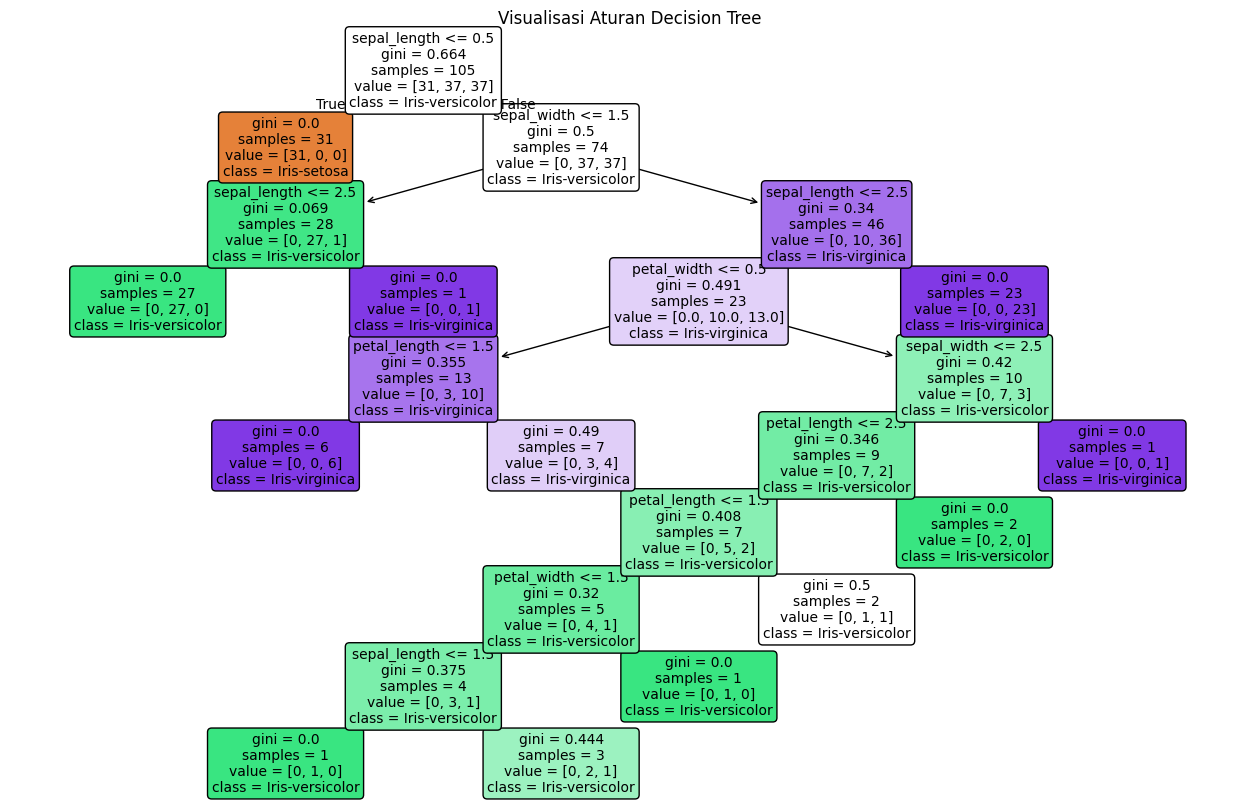

In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualisasi decision tree
plt.figure(figsize=(16, 10))
plot_tree(clf,
          feature_names=fitur,
          class_names=clf.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Visualisasi Aturan Decision Tree")
plt.show()


### Klasifikasi Decision Tree tanpa Data Binning dan diskretisasi

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Fitur dan label
fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'Class'

X = df_merged[fitur]
y = df_merged[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Latih model Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = tree_model.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nKlasifikasi:\n", classification_report(y_test, y_pred))



Akurasi: 1.0

Klasifikasi:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45



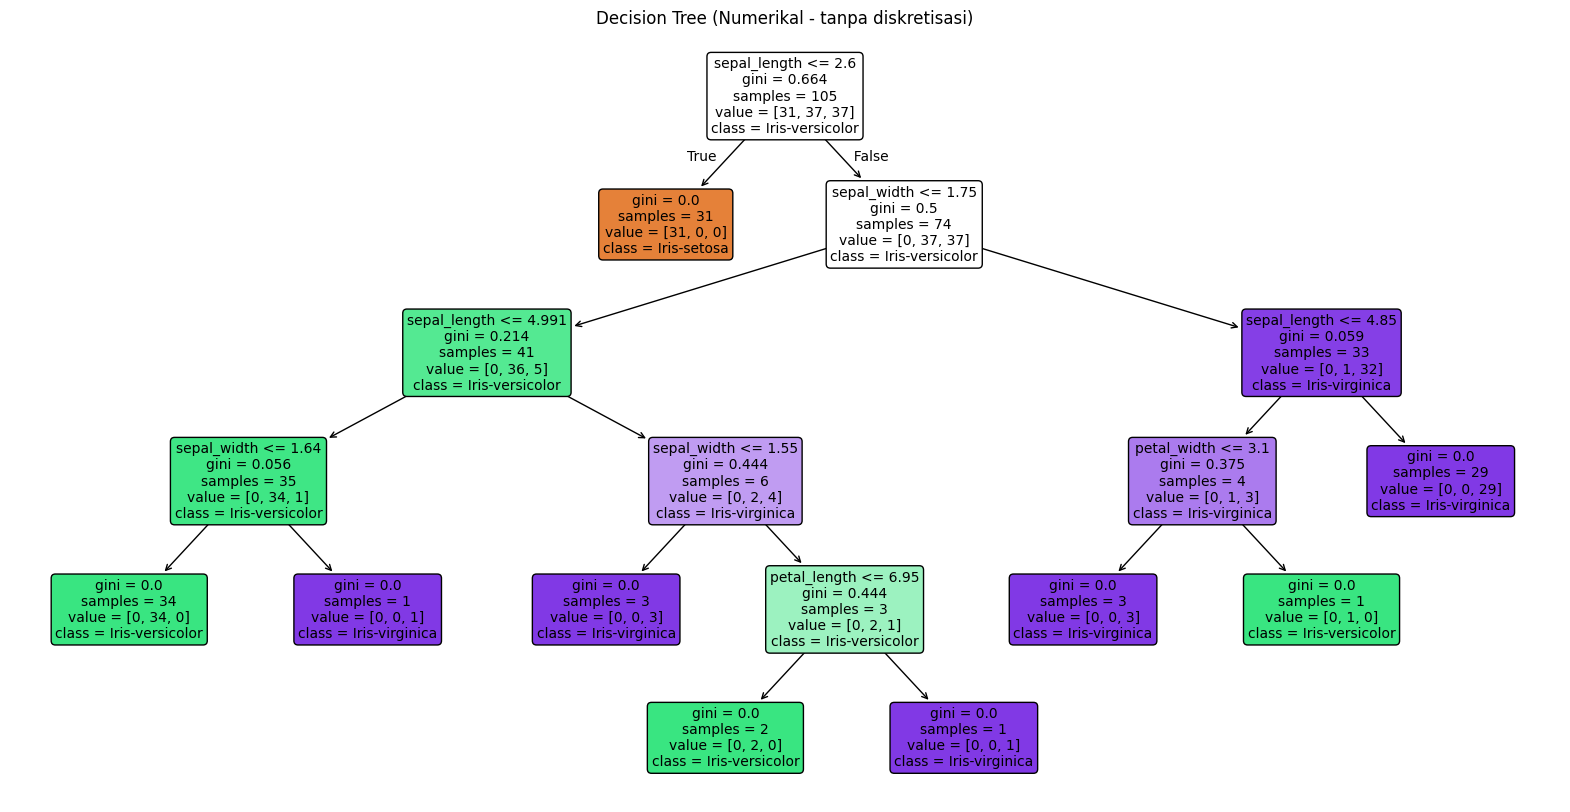

In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualisasi pohon keputusan
plt.figure(figsize=(20, 10))
plot_tree(tree_model,
          feature_names=fitur,
          class_names=tree_model.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree (Numerikal - tanpa diskretisasi)")
plt.show()


## Kesimpulan

Decision Tree memiliki akurasi model klasifikasi yang lebih baik pada Data Iris kategorikal dibandingkan dengan Naive Bayes Kategorikal  